In [2]:
import numpy as np

from qiskit import *
from qiskit.tools.monitor import job_monitor

from qiskit import assemble,pulse,QuantumCircuit,schedule,transpile
from qiskit.pulse.channels import ControlChannel, DriveChannel

from qiskit.circuit import Gate
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeArmonk, FakeValencia
from qiskit.visualization import plot_histogram

from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXDebugging,IQXStandard

# Access qubit property by using Qiskit Pulse

<div class="alert alert-block alert-info">
This part comes from the <a href="https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html">Calibrating Qubits with Qiskit Pulse</a> of a Qiskit Textbook. </div>


Qubit has several properties and you can check each of it through IQX platform.
To check the qubit properties of the FakeValencia backend, we can use this command as we've seen at lecture1.


In [4]:
backend = FakeValencia()

from qiskit.tools.jupyter import *
backend

<FakeValencia('fake_valencia')>

The **T1** and **T2** is usually called as "decoherence time"
- T1: T1 is usually called by (Longitudinal) relaxation time
- T2: T2 is uaually called by (Transverse) dephasing time


T1 is a measure of how quickly a qubit in the excited (|1⟩) state spontaneously relaxes to the ground (|0⟩) state.
T2 is a measure of how fast a coherent superposition loses its phase information. 

Our qubit is a superconducting qubit - transmon and we can treat this as a simple quantum harmonic oscillator with two-state. Like other harmonic oscillators, transmon qubit has a transition frequency between $|0\rangle$ and $|1\rangle$ state. the **Frequency** of a qubit is usually defined as the frequency of its microwave resonator and the physical interpretation is the energy difference between $|0\rangle$ and $|1\rangle$.

**Readout error** is the probability of a measurement returning the wrong value.

In near-term quantum computers, the major noise comes from - SPAM, State Preparation and Measurement- and CX gate. You can check this easily by taking a look at the above table, the readout error has  70 times bigger than the X gate.

Even the qubit property is pre-defined but the qubit condition changes frequently - especially the actual backend case, it can be different from time to time. 
Here, we will do three pulse experiments to measure the qubit property exactly. I first, planned to get the three qubit properties - Qubit frequency T1 and T2, but due to the pulse simulator limitation, I will only cover two, except T2 here.

## Measure the qubit frequency by the frequency sweep experiment

Before doing our own experiments, let's get the pre-defined value from the backend. Since we will use only one qubit for this whole lecture, we will use the ibmq_armonk and the pulse simulator with importing its system model.

In [5]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [6]:
backend_config = backend.configuration()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


The dt is a sampling time. So if we use a pulse with a duration of 10, it means the actual running time of this pulse is 2.22ns. This is fixed and cannot be changed by outside. Backend configuration has many properties and you can check the whole list [here](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html).

To check the pulse properties, you can use the defaults command. It contains almost every configuration of the pulse and you can check here for the whole properties. We can import the pre-defined qubit frequency by using qubit_freq_est and let's check the 0th qubit's estimated frequency of the ibmq_armonk in Hz.

In [7]:
backend_defaults = backend.defaults()

#get the qubit frequency of Qubit0
q0_freq = backend_defaults.qubit_freq_est[0]
print(f"Qubit 0 has an pre-defined frequency of {q0_freq} Hz.")


Qubit 0 has an pre-defined frequency of 4971588800.651904 Hz.


Some of you may recognize it, and we've already been used it at our part1 lecture to get the "measure" pulse schedule. Again, let's check the `measure` pulse schedule of ibmq_armonk. 

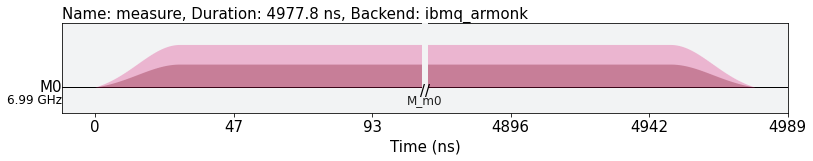

In [8]:
#get the measure pulse sequence of Qubit0

meas_sched = backend_defaults.instruction_schedule_map.get('measure', [0])
draw(meas_sched, backend = backend)

Now it's our turn to start our frequency sweep experiments. 

To get the qubit frequency, we will do simple experiment and the steps will be like this:
1. Prapare a list of the qubit frequency to swap. 
1. Get the X-Gate pulse sequence from the backend and build x_pulse with this.
1. Build a experimental schedules with 
    1. setting qubit frequency with the swap value
    1. play x_pulse onto Q0 which initialized into $|0\rangle$ state
    1. measure it with meas_level=1 to get the full complex number measured state
    1. plot the result with the real part and get the peak freaquency by fitting.

First, let's make a list of the frequency for this frequency swap experiment.

In [9]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = q0_freq       # The default frequency is given in Hz

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

The sweep will go from 4.951588800651904 GHz to 4.991588800651904 GHz in steps of 1.0 MHz.


To set-up a swap pulse, at here, we will use the X-Gate pulse. To check the pre-defined pulse schedule, run below code and build a x_pulse with this parameters to use. 

In [10]:
qc = QuantumCircuit(1)
qc.x(0)
qc_t = transpile(qc, backend)
qc_sched = schedule(qc_t, backend)
qc_sched.flatten

<bound method Schedule.flatten of Schedule((0, Play(Drag(duration=320, amp=(0.9051783795364403+0j), sigma=80, beta=-1.0111553175219203, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="circuit-2")>

In [11]:
with pulse.build(backend=backend, name='X_Pulse') as x_pulse:
    pulse.play(pulse.Drag(duration=320, amp=(0.9051783795364403+0j), sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))


Then build a pulse schedule by using `pulse.build` and here we will build `parameterized` shedule to put frequency as a parameters. Qiskit provide you a `qiskit.circuit.Parameter` class, usually used to build a parameterized quantum circuit for VQE or other quantum algorithm. But here, we will use this to build our experiment.

In [13]:
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.

freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    pulse.set_frequency(freq, pulse.drive_channel(0))
    pulse.call(x_pulse)
    # Define our measurement pulse
    pulse.measure(0)     


In [14]:
#insert frequency as a parameters and assign it into the schedules list.
frequencies_Hz = frequencies_GHz*GHz
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

let's draw the last schedule to check.

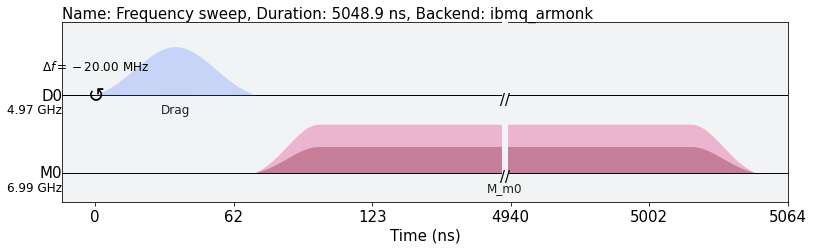

In [15]:
draw(schedules[0], backend=backend)

As I mentioned at Lecture1, the pulse simulator and fakeBackend not support `set_frequency`, so this time we will send jobs to the ibmq_armonk. It will takes times. So you can run this later to follow the lecture.

In [13]:
backend = provider.get_backend('ibmq_armonk')

num_shots_per_frequency = 2048

job = backend.run(schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In above code, you can see `meas_level`. meas_level=0 returns raw data (an array of complex values per shot), meas_level=1 returns kerneled data (one complex value per shot), and meas_level=2 returns classified data (a 0 or 1 bit per shot). We choose meas_level=1 to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the 'avg' of the results, rather than each shot individually.

In [14]:
#jobid : 617ac586a7212d1396cac090
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [17]:
retrieved_job = backend.retrieve_job('617ac586a7212d1396cac090')

In [18]:
frequency_sweep_results = retrieved_job.result()
print(len(frequency_sweep_results.results))
frequency_sweep_results.get_memory(1)[0]

41


(298734437007360+1376737405435904j)

As we've built 41 frequency sweep, the length of the `frequency_sweep_results` is 41. Because of we've been set the meas_level as 1, the simulation result need to accessed by use `get_memory(i)` method with i in range(41). the `[0]` means that the Qubit0. To get the state-relevant information, we only need a real part of it. So the frequency swap experiment result plot code will be like below:

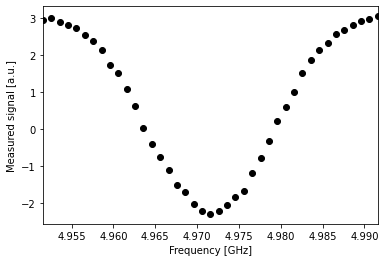

In [19]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows power-broadening, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will fit the values to a resonance response curve, which is typically a Lorentzian shape.

In [20]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [21]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

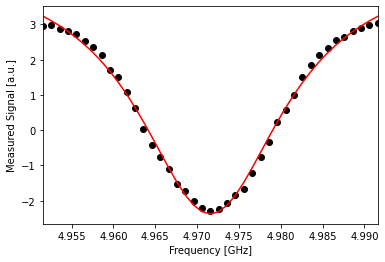

In [22]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [23]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97159 GHz to 4.9716 GHz.


Since the ibmq_armonk is also one of the simulator type, the result is almost same. 

### Amplitude sweep experiment to build a best x_pulse

Before go further, here we'll check the performance of our x_pulse since it's been so long time the pulse system model built. To get the best x_pulse, we will do `amplitude swap` - the rabi experiment. The process is similar with the above frequency sweep experient and the steps are as below:
- prepare amplitude sweep list
- do pulse experiment with a Drag pulse only change the amplitude with meas_level =1
- Get the real part of return, find the best amplitude between the lowest value and maximum value by fittint the data into the sinusoidal function.

First, set the amplitude swap range and the amplitude list for our experiment.

In [25]:
num_rabi_points = 75 #max number of circuit number to the ibmq_armonk is 75

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 1
drive_amp_min = 0
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

Next, build a amplitude sweep experiment. Since the measured qubit frequency is same as the pre-defined one, no frequency_set is needed. At here I used same pulse properties of x_pulse except the amplitude. 

In [26]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    pulse.play(pulse.Drag(duration=320, amp=drive_amp, sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))
    pulse.measure(0)

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

Now, run the experiment with `ibmq_armonk`. As this experiemtn does not have set_frequency, you can try this with the `FakeArmonk`. But I will use the `ibmq_armonk` to get more precise result.

In [121]:
#backend = FakeArmonk()

num_shots = 8192

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

ibmqfactory.load_account:WARNING:2021-10-29 01:51:07,436: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [122]:
rabi_results = job.result()

In [35]:
retrieved_job = backend.retrieve_job('617ad505dd41860550aedc25')

In [36]:
rabi_results = retrieved_job.result()

Now that we have our results, we will extract them and fit them to a sinusoidal curve.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a  π pulse. for nice fit, define the `baseline_remove` to make the mean of our sinusoidal curves 0.

In [37]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

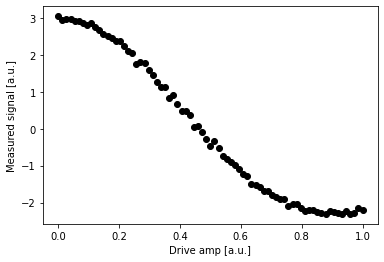

In [38]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

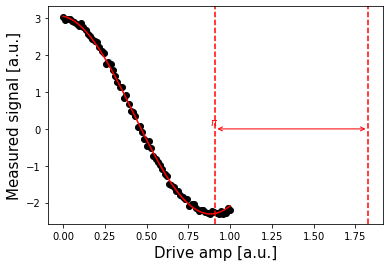

In [39]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 3, 1, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [40]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.9116700402723725


With proper fit, we've get `0.9116700402723725` for the optimal value for our x_pulse. FYI, our previouse x-pulse amplitude was `0.9051783795364403`. Then, let's see how it works and compare this with our previous x_pulse. At here, just use get_count to use default Discriminatator.

In [141]:
#backend = FakeArmonk()
num_shots_per_point = 8192

with pulse.build(backend=backend, default_alignment='sequential') as test_x_pulse:
    pulse.call(x_pulse)
    pulse.measure(0)

job = backend.run(test_x_pulse, shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [41]:
retrieved_job = backend.retrieve_job('617ad813a7212dd744cac0e2')

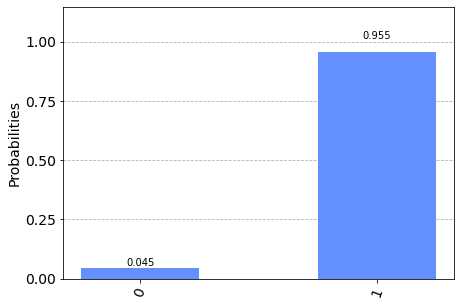

In [42]:
results = retrieved_job.result()
plot_histogram(results.get_counts())

 Now, let's try our new x_pulse:

In [46]:
#define new x pulse
with pulse.build(backend=backend, default_alignment='sequential') as new_x_pulse:
    pulse.play(pulse.Drag(duration=320, amp=pi_amp, sigma=80, beta=-1.0111553175219203), pulse.drive_channel(0))




In [ ]:
with pulse.build(backend=backend, default_alignment='sequential') as test_x_pulse:
    pulse.call(new_x_pulse)
    pulse.measure(0)

job_monitor(job)
job = backend.run(test_x_pulse, shots=num_shots_per_point).result()


In [43]:
retrieved_job = backend.retrieve_job('617adaf119bc9c01c2830666')

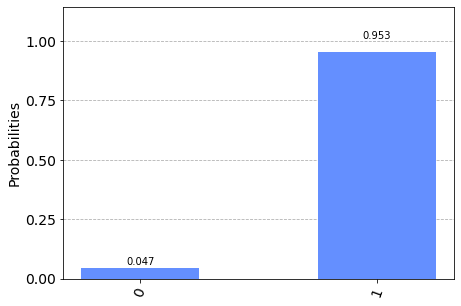

In [44]:
results = retrieved_job.result()
plot_histogram(results.get_counts())

At here, I used get_count() which call the default standard to determin the qubit state. Since our new_x_pulse works perfectly, we will not perform measurement optimization at here, but we will do that at the Part3.  With our new_x_pulse, let's go further experiment. At here let's make two pulse schedule to get the bunch of $|0\rangle$, $|1\rangle$ states then plot to see how it is well seperated. If not, let's discuss about this more.

### 0,1 state plot

In [47]:
# Create two schedules

# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    pulse.measure(0)


# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    pulse.call(new_x_pulse)
    pulse.measure(0)

In [154]:
num_shots = 8192

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


#backend = FakeArmonk()
job = backend.run([gnd_schedule, exc_schedule], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

ibmqfactory.load_account:WARNING:2021-10-29 02:40:52,089: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [51]:
retrieved_job = backend.retrieve_job('617ae0ada7212d24e5cac0f6')

In [53]:
gnd_exc_results = retrieved_job.result()
gnd_results = gnd_exc_results.get_memory(0)[:, 0]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, 0]*scale_factor


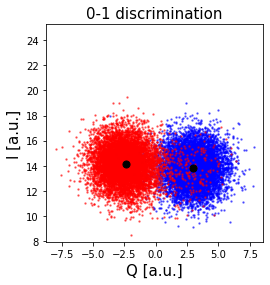

In [58]:
plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=2, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=2, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=50, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=50, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()






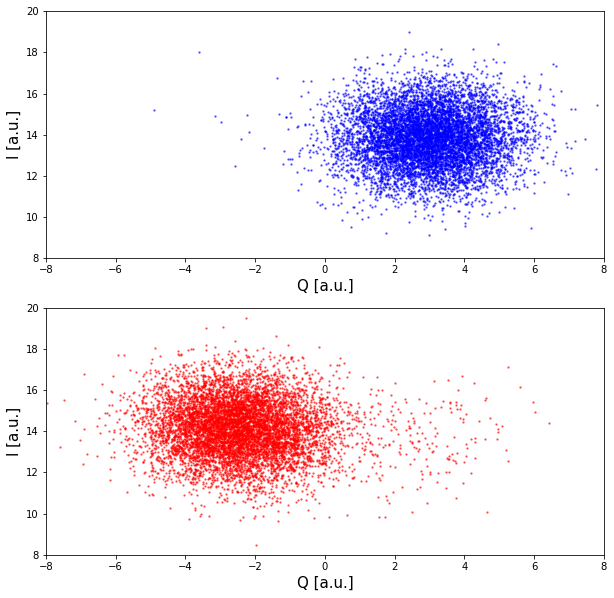

In [64]:
fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=2, cmap='viridis', c='blue', alpha=0.5, label='state_0')
ax[0].set_xlabel('Q [a.u.]', fontsize=15)
ax[0].set_ylabel('I [a.u.]', fontsize=15)
ax[0].set(xlim=(-8, 8), ylim=(8, 20))


ax[1].scatter(np.real(exc_results), np.imag(exc_results), 
                s=2, cmap='viridis', c='red', alpha=0.5, label='state_1')
ax[1].set_xlabel('Q [a.u.]', fontsize=15)
ax[1].set_ylabel('I [a.u.]', fontsize=15)
ax[1].set(xlim=(-8, 8), ylim=(8, 20))


plt.show()

In [70]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

By plotting each of the state measurement result, we can see the noise clearly - more noise from the $|1\range$ than $|0\rangle$. 

The interesting point is the $|0\rangle$ results. As you can see through our pulse schedule, 

    with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
        pulse.measure(0)
        
We've did nothing but only measure. There will be another noise source, but at here, we can guess the noise of the $|0\rangle$ is comes from the `measurement` - one of the SPAM error. 

By looking at the $|1\rangle$ state result, even we measured the qubit right after apply x-pulse, we can observe decoherence noise which heading for the $|0\rangle$ state from $|1\rangle$. This decoherence is relate with one of the qubit properties - the T1 time - and now let's measure that with our qubits.

## Measure the T1 of the Qubit

The  T1 time of a qubit is the time it takes for a qubit to decay from the excited state to the ground state. It is important because it limits the duration of meaningful programs we can run on the quantum computer.

Measuring  T1 is similar to our previous experiments, and will use the pre-defined x pulse with this. We again apply a single drive pulse, then apply a measure pulse. 

However, to see the decay, we insert a delay, and vary that delay between experiments. When we plot the measured signal against delay time, we will see a signal that decays exponentially as the qubit relaxes in energy. The decay time is the  T1, or relaxation time, of the qubit. 

At this time, we will again use the `meas_level=1` to get the full feature of the experiments.

In [65]:
# T1 experiment parameters
time_max_sec = 400 * us
time_step_sec = 10 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)
print(delay_times_sec)

[1.00e-06 1.10e-05 2.10e-05 3.10e-05 4.10e-05 5.10e-05 6.10e-05 7.10e-05
 8.10e-05 9.10e-05 1.01e-04 1.11e-04 1.21e-04 1.31e-04 1.41e-04 1.51e-04
 1.61e-04 1.71e-04 1.81e-04 1.91e-04 2.01e-04 2.11e-04 2.21e-04 2.31e-04
 2.41e-04 2.51e-04 2.61e-04 2.71e-04 2.81e-04 2.91e-04 3.01e-04 3.11e-04
 3.21e-04 3.31e-04 3.41e-04 3.51e-04 3.61e-04 3.71e-04 3.81e-04 3.91e-04]


In [66]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [166]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_sec:
    with pulse.build(backend=backend, default_alignment='sequential', name=f"T1 delay = {delay / ns} ns") as t1_schedule:
        drive_chan = pulse.drive_channel(0)
        pulse.call(new_x_pulse)
        pulse.delay(get_closest_multiple_of_16(pulse.seconds_to_samples(delay)), drive_chan)
        pulse.measure(0)
    t1_schedules.append(t1_schedule)

In [167]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
#backend = FakeArmonk()
num_shots = 8192

job = backend.run(t1_schedules, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

ibmqfactory.load_account:WARNING:2021-10-29 03:01:32,255: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [67]:
retrieved_job = backend.retrieve_job('617ae585bc98846ca95f9706')

In [68]:
t1_results = retrieved_job.result()

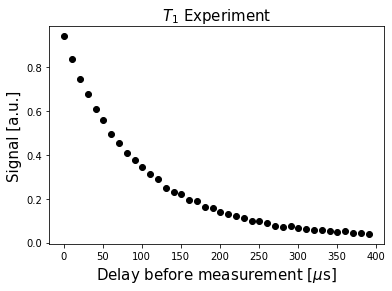

In [73]:
import matplotlib.pyplot as plt

t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / 8192)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

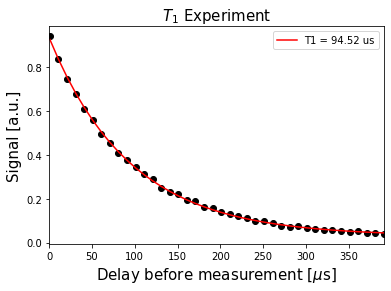

In [74]:
from scipy.optimize import curve_fit

# Fit the data

fit_params, y_fit = fit_function(delay_times_sec/us, np.real(t1_values), 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()